## Projeto 1

#### Aluno: Vitor Mazal Krauss

#### Objetivos:

- Elaborar um algoritmo que calcula a exponencial de uma matriz, seja ela defeituosa ou não.

- Usar a matriz exponencial para resolver sistemas de EDO's de primeira ordem em forma vetorial e fazer gráficos das soluções.

- Elaborar um algoritmo que transforma EDO's de ordem mais altas em um sistema de EDO's em forma vetorial e o resolve usando a matriz exponencial.



#### Parte 1: resolvendo sistemas de EDO's de primeira ordem 

##### Sistema de EDO's

Considere um sistema de EDO's de primeira ordem em forma matricial 

$$ \frac{d\mathbf{u}}{dt} = A\mathbf{u} + \mathbf{b} $$

com condição inicial $\mathbf{u}(0) = \mathbf{u}_0$.

A solução deste sistema é dada $[1]$, no caso em que $A$ é invertível, por:

$$ \mathbf{u}(t) = e^{At}\mathbf{u}_0 + A^{-1}(e^{At} - I)\mathbf{b} $$. 

Observe que no caso particular de $\mathbf{b} = 0$ não precisamos inverter $A$. Isso sugere que a função que resolve o sistema verifique se $\mathbf{b} = 0$, para evitar um cálculo desnecessário de $A^{-1}$.

##### Calculando a matriz exponencial

Com relação ao termo exponencial, devemos considerar dois casos: 

1. A é uma matriz diagonalizável(não defeituosa), i.e, existe uma matriz diagonal $D$ e uma matriz invertível $S$ tais que $A = SDS^{-1}$. 

2. A não é diagonalizável(defeituosa)

Da definição $e^A = \sum_{k=0}^{\infty} \frac{A^k}{k!}$, temos que para $A$ não defeituosa vale que $e^A = Se^D S^{-1}$, onde $e^D = diag(e^{\lambda_1}, \ldots, e^{\lambda_p})$, onde ${\lambda_1}, \ldots,{\lambda_p}$ são os autovalores de $A$.

No caso em que a matriz é defeituosa, o cálculo de $e^A$ ainda é possível. Note que mesmo se $A$ é defeituosa, podemos usar a sua decomposição de Jordan, i.e, usar o fato que $A = VJV^{-1}$, onde a matriz $J$ tem a forma canônica de Jordan. Uma vez que $J$ tem forma canônica de Jordan, podemos mostrar que $J = D + N$, onde $D$ é uma matriz diagonal e $N$ é nilpotente, ou seja, existe $k_0$ tal que $N^{k} = 0, \forall k \geq k_0$. Assim, usando a definição de $e^A$, podemos concluir que 

$$ e^A = V e^D \Big( \sum_{k=0}^{k_0 -1} \frac{N^k}{k!} \Big) V^{-1} $$

Assim, vemos que podemos resolver o sistema de EDO mesmo para matrizes defeituosas. Nosso algoritmo vai incorporar isso. Primeiro testaremos se a matriz $A$ é defeituosa ou não. Baseado no resultado deste teste, procederemos da maneira adequada. 

In [1]:
import numpy as np
from sympy import Matrix
from math import factorial
import scipy.linalg
import func_timeout as ft
import matplotlib.pyplot as plt
import time
from sympy.functions import re, im

In [2]:
def verify_matrix_simbolically(M):
    '''Verifica se a matriz M é não defeituosa ou defeituosa por meio de computação simbólica, através do SymPy. Retorna 
    True se é diagonalizável(não defeituosa) e False caso contrário.'''
    is_diagonalizable = Matrix(M).is_diagonalizable() # verificar se M é diagonalizável. Usando sympy por causa da computação simbólica
    return is_diagonalizable

In [3]:
def verify_matrix_numerically(M, precision=10**(-8)):
    '''Verifica se a matriz M é não defeituosa ou defeituosa numericamente. Se é diagonalizável(não defeituosa), retorna
    true. Se M não é diagonalizavel, retorna False. Faz essa verificação verificando se os autovetores são linearmente 
    independentes atraves do determinante, ou seja, numericamente'''
    M = np.array(M) # certificando-se de que M é um objeto da classe np.array
    eigenvalues, S = np.linalg.eig(M) #diagonaliza a matriz, de forma que M = SDS^-1. A matriz S tem os autovetores como coluna
    det = np.linalg.det(S) # calcula o determinante de S
    if (abs(det) < precision): return False #caso determinante aproximadamente zero, matriz defeituosa
    else: return True

In [4]:
def diagonalizable_exponential(M):
    '''Recebe uma matriz M não defeituosa e calcula e^M.'''
    M = np.array(M) # certificando-se de que M é um objeto da classe np.array
    eigenvalues, S = np.linalg.eig(M) #eigenvalues é o array com os autovalores de M
    # S é a matriz cujas colunas são os autovetores de M
    S_inv = np.linalg.inv(S) #calcula a inversa de S
    exp_D = np.diag(np.exp(eigenvalues)) # cria a matrix e^D com e^lambda_i na diagonal
    return np.matmul(np.matmul(S, exp_D), S_inv) # retorna S*e^D*S^-1

In [5]:
def non_diagonalizable_exponential(M):
    '''Recebe uma matriz M defeituosa e calcula e^M da maneira descrita acima no texto'''
    M_simbolic = Matrix(M) # fazendo com que M seja um objeto Matrix do SymPy(ou seja, uma matriz simbolica)
    V, J = M_simbolic.jordan_form() # calculando a forma canonica de Jordan da matriz M = V*J*V^-1.
    V = np.array(re(V), float) + 1j*np.array(im(V), float) # convertendo de matriz do sympy(simbólica) para numpy(numérica)
    J = np.array(re(J), float) + 1j*np.array(im(J), float) #igualmente
    V_inv = np.linalg.inv(V) # calculando a inversa de V
    D = np.diag(np.diag(J)) # cria uma matriz diagonal copiando a diagonal principal de J
    N = J - D # cria matriz triangular superior e nilpotente N removendo a diagonal principal de J
    #Agora D é uma matriz diagonal. Logo é não defeituosa e podemos usar o método diagonalizable exponential para e^D
    exp_D = diagonalizable_exponential(D)
    #N é uma matriz nilpotente. Logo a série(infinita) que aparece na expansao de e^N se torna uma soma finita
    # o código a seguir calcula esta soma finita
    exp_N = np.identity(len(N), float) + N # inicializa a soma com os dois primeiros termos
    N_k = np.matmul(N,N) # = N^2. é o primeiro caso do laço
    i = 2 # indice. precisamos para calcular o fatorial
    zero_matrix = np.full((len(N), len(N)), 0.0, float) # matriz apenas de zeros com dimensão igual a de N
    while(not np.allclose(N_k, zero_matrix)): # a condição de parada é N^k = 0
        exp_N = exp_N + np.multiply(1/factorial(i), N_k) # soma (N^k)/k! a soma já acumulada
        N_k = np.matmul(N_k, N) # N^k = N^(k-1) * N
        i += 1
    return np.matmul(np.matmul(np.matmul(V, exp_D), exp_N), V_inv) #e^M = V*e^D*e^N*V^-1

Agora podemos implementar a função *matrix_exponential*, que retorna $e^M$ para qualquer matriz $M$, sendo ela defeituosa ou não. O primeiro passo é verficar se M é diagonalizável ou não. Primeiro, fazemos essa verificação através de computação simbólica devido a maior confiabilidade. Porém, isso pode acabar demorarando muito dependo da matriz e sua dimensão. Por isso, colocamos uma tolerância de tempo $t$. Se o tempo de execução da verificação simbólica ultrapassar $t$, abortamos a verificação simbólica e fazemos a verificação numérica.

In [6]:
def matrix_exponential(M):
    '''Recebe uma matriz M(defeituosa ou não) qualquer e calcula e^M. Escolhe a forma adequada de calcular e^M dependendo de
    M ser defeituosa ou não'''
    t = 20 # tolerancia, em segundos
    is_diagonalizable = None
    try:
        is_diagonalizable = ft.func_timeout(t, verify_matrix_simbolically, args=(M,)) #tentamos a verificação simbólica
        # com tolerancia de t segundos
    except: 
        pass # Se ultrapassar o tempo, ou seja, levantar uma exceção, ainda prosseguimos para o resto da função
    if(is_diagonalizable): #Se M é diagonalizavel(simbolicamente)
        exp_M = diagonalizable_exponential(M) #chama o método para matrizes diagonalizaveis
    elif(not is_diagonalizable): #Se M é não diagonalizavel(simbolicamente)
        exp_M = non_diagonalizable_exponential(M) # chama o método para matrizes não diagonalizaveis
    else: # entra nesse caso se tiver excedido o tempo de tolerancia
        is_num_diagonalizable = verify_matrix_numerically(M) #Testamos numericamente se é diagonalizavel ou não
        if(is_num_diagonalizable == False): #Se M é não diagonalizavel(numericamente)
            exp_M = non_diagonalizable_exponential(M) # método para M não diagonalizavel
        else: # Se M é diagonalizavel(numericamente)
            exp_M = diagonalizable_exponential(M) #chama o metodo para matrizes diagonalizaveis
    return exp_M

##### Resolvendo o sistema

Agora que já temos como calcular $e^M$ para qualquer matriz $M$, podemos finalmente resolver o sistema. 

Lembramos que a solução é dada por:

$$ \mathbf{u}(t) = e^{At}\mathbf{u}_0 + A^{-1}(e^{At} - I)\mathbf{b} $$

O seguinte método recebe $A, \mathbf{b}$ e $\mathbf{u}_{0}$ e retona a solução $u(t)$ como um método que recebe o parâmetro $t_0$ e retorna $u(t_0)$.

In [7]:
def Solve_ODE_System(A, b, u_zero):
    '''Resolve o sistema du/dt = Au + b com condição inicial u_zero. Retorna a função solução'''
    A = np.array(A) # certificando que A é um objeto da classe numpy.array
    b = np.array(b) # igualmente
    u_zero = np.array(u_zero)
    def exp_At(t): # funcao e^At como função de t
        return matrix_exponential(np.multiply(t, A)) 
    zero = np.zeros(len(b)) # vetor zero
    if(np.array_equal(b, zero)): # se b==0, a solucao é apenas o primeiro termo e nao precisamos inverter A
        def solution(t):
            return np.dot(exp_At(t), u_zero)
    else: # se b!=0, a solucao envolve os dois termos e precisamos inverter A
        A_inv = np.linalg.inv(A)  # inversa de A
        ID = np.identity(len(A))  # matriz identidade com mesma dimensao de A
        def solution(t):
            return np.dot(exp_At(t), u_zero) + np.dot(np.matmul(A_inv, exp_At(t) - ID), b)
    return solution  # retorna u(t) como funcao

#### Parte 2: fazendo gráficos

Nosso objetivo agora é fazer gráficos das soluções de um sistema.

O método acima nos retorna a solução do sistema como função. Ou seja, ela nos retorna uma função que,para qualquer $t$, nos dá $\mathbf{u}(t)$. Cada chamada de $\mathbf{u}(t)$ faz uma chamada da função *matrix_exponential* e, consequentemente, faz os testes e cálculos que fazem parte de *matrix_exponential*. Por outro lado, se o nosso objetivo é fazer gráficos, teremos que avaliar $\mathbf{u}(t)$ para vários valores de $t$. Argumentamos que, neste caso(em que a matriz $A$ é fixa e queremos valores de $\mathbf{u}(t)$ para vários valores de $t$) há uma forma mais efieciente(rápida) de calcular $e^At$ nos diversos pontos do que simplesmente chamar o método *matrix_exponential* para cada valor de $t$. 

Observe que $M$ é diagonalizável $\iff$ $Mt$ é diagonalizável para cada $t \in \mathbb{R}$. Assim, só precisamos testar se A é defeituosa ou não apenas uma vez. Fazer várias chamadas seguidas de *matrix_exponential* vai levar a verificações desnecessárias.

No caso de matrizes diagonalizáveis, so precisamos calcular $S$ e $D$ tais que $M = SDS^{-1}$ uma vez. Daí, para cada $t$, basta calcular $e^Dt$, e depois fazer $e^Mt = Se^DtS^{-1}$.

No caso de matrizes defeituosas, primeiro é necessário encontrar sua forma canonica de Jordan $M = VJV^{-1}$(o que só precisa ser feito uma vez) e, em seguida, calcular potências $N, N^2, \ldots, N^{k_0 -1}$ da matriz $N$ tal que $J=D+N$. Basta calcular estas potencias uma vez e armazená-las na memória. Depois, para cada $t$, multiplicamos cada uma por $t, t^2, \ldots, t^{k_0 -1}$, para obter $e^{Nt} = \sum_{k=0}^{k_0 -1} \frac{t^k N^k}{k!}$. Daí, temos que $e^M = V e^D e^N V^{-1}$.

In [8]:
def vectorized_matrix_exponential(M, ts):
    '''Recebe uma matriz qualquer M e uma lista de valores reais ts e calcula e^Mt para cada t em ts de forma mais eficiente.
    Evita repetir verificações e o cálculo de potências'''
    t = 20 #tolerancia, em segundos
    exp_Mts = [None]*len(ts) # vai retornar uma lista com os valores de e^Mt, onde t pertence a ts
    is_diagonalizable = None
    def diagonalizable():
        '''Funcao vetorizada a ser chamada se M é diagonalizavel'''
        eigenvalues, S = np.linalg.eig(np.array(M)) # diagonaliza a matriz, ie, M = SDS^-1
        S_inv = np.linalg.inv(S) # inverte S
        for i in range(len(ts)): # para cada t pertencente a ts
            exp_D = np.diag(np.exp(np.multiply(ts[i],eigenvalues))) #calcula e^Dt para cada t
            exp_Mts[i] = np.matmul(np.matmul(S, exp_D), S_inv) # armazenamos e^Mt = S*e^Dt*S^-1
    def non_diagonalizable():
        '''Funcao vetorizada a ser chamada se M é não diagonalizavel'''
        M_simbolic = Matrix(M) # fazendo com que M seja um objeto Matrix do SymPy
        V, J = M_simbolic.jordan_form() # calculando a forma canonica de Jordan da matriz M = V*J*V^-1.
        V = np.array(re(V), float) + 1j*np.array(im(V), float) # convertendo de matriz do sympy(simbólica) para numpy(numérica)
        J = np.array(re(J), float) + 1j*np.array(im(J), float) #igualmente
        V_inv = np.linalg.inv(V) # calculando a inversa de V
        D = np.diag(np.diag(J)) # cria uma matriz diagonal copiando a diagonal principal de J
        N = J - D # cria matriz triangular superior e nilpotente N removendo a diagonal principal de J
        #N é uma matriz nilpotente. Logo a série(infinita) que aparece na expansao de e^N se torna uma soma finita
        # o código a seguir calcula esta soma finita
        N_powers = [np.identity(len(N), float), N] # inicializa a lista de potencias com os dois primeiros termos
        N_k = np.matmul(N,N) # = N^2. é o primeiro caso do while
        i = 2 # indice. precisamos para calcular o fatorial
        zero_matrix = np.full((len(N), len(N)), 0.0, float) # matriz apenas de zeros com dimensão igual a de N
        while(not np.allclose(N_k, zero_matrix)): # a condição de parada é N^k = 0
            N_powers.append((np.multiply(1/factorial(i), N_k))) # inclui (N^k)/k! na lista de potencias
            N_k = np.matmul(N_k, N) # N^k = N^(k-1) * N # iterador
            i += 1
        for i in range(len(ts)):
            exp = diagonalizable_exponential(np.multiply(ts[i], D)) #para cada t, calculamos e^Dt
            soma = np.full((len(N), len(N)), 0.0, float)  # inicializa a soma em zero
            for j in range(len(N_powers)):
                soma = soma + np.multiply(ts[i]**j, N_powers[j])  # soma o j-esimo termo de e^Nt = I + tN + (t^2 N^2)/2! + ...
            exp_Mts[i] = np.matmul(np.matmul(np.matmul(V, exp), soma),V_inv) # armazena e^Mt = V*e^Dt*e^Nt*V^-1
    try:
        is_diagonalizable = ft.func_timeout(t, verify_matrix_simbolically, args=(M,)) #tentamos a verificação simbólica
        # com toleranica de t segundos
    except: 
        pass # Se ultrapassar o tempo, ou seja, levantar uma exceção, ainda prosseguimos com a função
    if(is_diagonalizable): # Se a matrix M é diagonalizavel(simbolicamente)
        diagonalizable()
    elif(not is_diagonalizable): # Se M é não diagonalizavel(simbolicamente)
        non_diagonalizable()
    else:  # Entra nesse caso se o tempo de tolerancia foi excedido
        is_num_diagonalizable = verify_matrix_numerically(M) # Agora testamos numericamente se é diagonalizavel ou não
        if(is_num_diagonalizable == True): # Caso em que a matriz é diagonalizável(verificado numericamente)
            diagonalizable()
        else: # Caso em que a matriz não é diagonalizável
            non_diagonalizable()
    return exp_Mts

Abaixo, fazemos uma comparação entre calcular $e^{At}$ em $10^4$ pontos utilizando o método anterior *vectorized_matrix_exponential*, que calcula todos em uma única chamada, ou chamar o método *matrix_exponential* para cada um dos pontos.

In [9]:
A = np.array([[-1,0,0], [1,-1,0], [0,1,-1]])

In [10]:
start = time.time()
vectorized_matrix_exponential(A, np.linspace(0,1,10**4))
end = time.time()
print("vetorizado, tempo em segundos = ", end - start)

vetorizado, tempo em segundos =  3.6798415184020996


In [11]:
start = time.time()
[matrix_exponential(np.multiply(1,A)) for t in np.linspace(0,1,10**4)]
end = time.time()
print("escalar, tempo em segundos = ", end - start)

escalar, tempo em segundos =  104.03289151191711


A otimização é enorme.

Vemos que, de fato, dada uma matriz $M$, para o cálculo de $e^{Mt}$ em diversos valores de $t$, o método *vectorized_matrix_exponential* é muito mais rápido. 

Observe, porém, que o método *matrix_exponential* é mais eficiente em termos de memória, pois não armazena as matrizes $N, N^2, \ldots, N^{k_0 - 1}$. Note que, se desejamos calcular $e^{Mt}$ para um único valor de $t$, a complexidade dos dois métodos, em termos de operações, é a mesma, e em termos de memória, é favorável ao *matrix_exponential*.

In [12]:
def exibe_solucao_1(A, b, u_zero, t=1, M=10**3, select=False, fig=None, ax=None, retorno=False):
    '''Dados A, b, u_zero tais que du/dt = Au + b, com u(0) = u_zero, exibe, em um único gráfico, as solucoes em todas as
    coordenadas do vetor. t é um argumento opcional para o intervalo a ser considerado [0,t]. M é um argumento opcional para
    o número de pontos a serem plotados. O argumento select permite escolher quais coordenadas serão plotadas. Se retorno 
    igual a True, a função tambem retorna as listas que foram plotadas.'''
    A = np.array(A) # certificando que A é um objeto da classe numpy.array
    b = np.array(b)
    n = len(b)
    u_zero = np.array(u_zero)
    ts = np.linspace(0, t, M) # discretização do dominio
    exp_ts = vectorized_matrix_exponential(A, ts) # valores de e^At para cada t pertencente a ts
    zero = np.zeros(len(b)) # vetor zero
    if(np.array_equal(b, zero)):  # se b é igual a zero 
        us = [np.dot(exp, u_zero) for exp in exp_ts]
    else: # se b é diferente de zero
        A_inv = np.linalg.inv(A) # precisamos inverter A
        ID = np.identity(len(A), float) #matriz identidade com a mesma dimensão de A
        us = [np.dot(exp, u_zero) + np.dot(np.matmul(A_inv, exp - ID), b) for exp in exp_ts] #lista com os vetores solução
    to_plot = [[u[i] for u in us] for i in range(n)] # separa as coordenadas dos vetores solução
    if((fig == None) and (ax == None)): # se nenhuma figura e axes foram passados, entao criamos 
        fig, ax = plt.subplots(ncols=1, nrows=1)    
    for i in range(n):
        if(not select):  # se nenhuma coordenada foi especificada, plotamos todas
            ax.plot(ts, to_plot[i], label='x_'+str(i)) # plotando a coordenada 
        else: # se alguma coordenada foi especificada
            if(select.count(i) == 1):  # verificamos se a coordenada foi escolhida
                ax.plot(ts, to_plot[i], label='x_'+str(i)) # se foi escolhida, plotamos
    plt.legend()
    plt.show()
    if(retorno == True): return to_plot

###### Exemplo:

Considere uma EDO da forma:

$$ \frac{d\mathbf{u}}{dt} = A\mathbf{u} + \mathbf{b} $$

onde $ A = 
\begin{pmatrix}
3 & -4 \\
1 & -1
\end{pmatrix}  $
e $\mathbf{b} = 0$.

Podemos calcular $e^{At}$ de forma explícita e obtemos que $e^{At} = 
\begin{pmatrix}
(2t+1)e^t & -4te^t \\
te^t & -(2t-1)e^t
\end{pmatrix}
$.

Como $\mathbf{b} = 0$, a solução é $\mathbf{u}(t) = \begin{pmatrix}
(2t+1)e^t & -4te^t \\
te^t & -(2t-1)e^t
\end{pmatrix} \mathbf{u_0}$

Abaixo, fazemos um plot da solução calculando explicitamente a matriz exponencial usando a expressão acima. Chamamos essa solução de 'explícita'. Também vamos plotar a solução através do método *exibe_solucao_1*, que faz exponenciação com o método *vectorized_matrix_exponential* e, por isso, chamaremos de solução 'implicita'.

C:\Users\vmk10\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


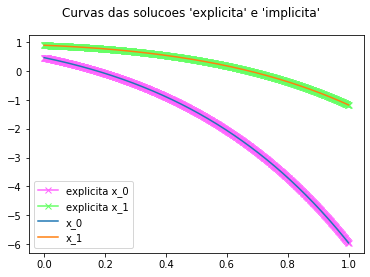

In [13]:
def example_matrix(t):
    return np.array([[(2*t + 1)*np.exp(t), -4*t*np.exp(t)],[t*np.exp(t), -1*(2*t - 1)*np.exp(t)]])
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.suptitle("Curvas das solucoes 'explicita' e 'implicita'")
ts = np.linspace(0, 1, 10**3)
A = np.array([[3,-4],[1,-1]])
u_zero = np.random.rand(2)
b = np.array([0,0])
analitical_solution = [np.dot(example_matrix(t), u_zero) for t in ts]
to_plot = [[u[i] for u in analitical_solution] for i in range(2)]
colors = ['#ff66ff', '#66ff66']
for i in range(2):
    ax.plot(ts, to_plot[i], 'x-', label='explicita x_' + str(i), color=colors[i])
num = exibe_solucao_1(A, b, u_zero, fig=fig, ax=ax, retorno=True)

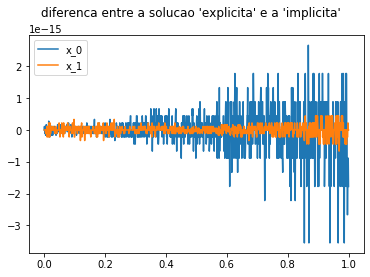

In [14]:
for i in range(2):
    plt.plot(ts, (np.array(num[i])- to_plot[i]), label='x_' + str(i))
plt.legend()
plt.suptitle("diferenca entre a solucao 'explicita' e a 'implicita'")
plt.show()

A pequena diferença ocorre devido a erros numéricos involvendo floats e pela diferença de calcular $e^{At}$ de forma explícita(através do método *example_matrix*) e calcular $e^{At}$ pelo método geral *vectorized_matrix_exponential*. Apesar da pequena diferença, ambas curvas representam a mesma solução, que é a solução analítica do problema.

#### Parte 3: resolvendo EDO's de ordem mais alta

Considere a EDO de ordem $n$ a seguir:

$$ a_n \frac{d^n u}{dt^n} + a_{n-1} \frac{d^{n-1} u}{dt^{n-1}} + a_{n-2} \frac{d^{n-2} u}{dt^{n-2}} + \ldots + a_1 \frac{du}{dt} + a_0 u = C $$

Podemos transformar esta EDO de ordem $n$ em um sistema de primeira ordem da forma $ \frac{d\mathbf{u}}{dt} = A\mathbf{u} + \mathbf{b} $.

Para isso, definimos o vetor $\mathbf{x} = (x_0, \ldots, x_{n-1})$ tal que $x_0 = u, x_1 = \frac{du}{dt}, \ldots , x_{n-1} = \frac{d^{n-1} u}{dt^{n-1}}$.

Daí, podemos ver que $\frac{d x_0}{dt} = x_1, \frac{d x_1}{dt} = x_2, \ldots, \frac{d x_{n-2}}{dt} = x_{n-1}$ e, substituindo na equação,

$$\frac{d x_{n-1}}{dt} = \frac{1}{a_n} \Big( -a_0 x_0 - a_1 x_1 - \ldots a_{n-2} x_{n-2} \Big) + \frac{C}{a_{n}} $$

Assim, definindo 

$$ A = 
\begin{pmatrix}
0 & 1 & 0 & \ldots \\
0 & 0 & 1 & 0 & \ldots \\
0 & 0 & 0 & 1 & 0 & \ldots \\
& & &\vdots & \\
0 & 0 & 0 & \ldots & 0 & 1 \\
\frac{-a_0}{a_n} & \frac{-a_1}{a_n} & \frac{-a_2}{a_n} & \ldots & \frac{-a_{n-2}}{a_n}  & \frac{-a_{n-1}}{a_n}  
\end{pmatrix}  $$


$$\mathbf{b} = (0, 0, \ldots, 0, \frac{C}{a_n})$$

e dada uma condição inicial $\mathbf{u}_0$, basta agora resolver o sistema $ \frac{d\mathbf{u}}{dt} = A\mathbf{u} + \mathbf{b} $ com esta condição inicial. A solução $u(t)$ da EDO original é dada pela coordenada $x_0$ de $\mathbf{x}$.

In [15]:
def reduce_higher_order_system(a, u_zero):
    '''Recebe uma lista a dos coeficientes da ED de ordem n com coeficientes na lista a e condição inicial u_zero. 
    Transforma essa ED em uma ED em forma vetorial de primeira ordem du/dt = Au + b'''
    n = len(a) - 2
    A = np.full((n,n), 0.0, float)
    for i in range(n-1): # Constroi a matriz A
        A[i][i+1] = 1.0  # preenchendo a diagonal secundaria com 1
        A[n-1][i] = (-1)*a[-i-2]/a[0] # aproveitamos o for para preencher a ultima linha também
    A[n-1][n-1] = (-1)*a[1]/a[0] # so faltou preencher a ultima entrada da matriz
    b = np.full((n), 0.0, float)
    b[-1] = a[-1]/a[0] # apenas a ultima coordenada de b é diferente de zero
    return [A, b, u_zero]

In [16]:
def exibe_solucao_2(a, u_zero, t=1,sel=[0], figu=None, axe=None, ret=False):
    '''Faz um grafico da solucao de uma EDO de ordem n com coeficientes da lista a e condicao inicial u_zero'''
    reduced = reduce_higher_order_system(a, u_zero) # transformar EDO de ordem n para sistema de ordem 1
    if(ret == True): return exibe_solucao_1(reduced[0], reduced[1], reduced[2], t=t, select=sel, fig=figu, ax=axe, retorno=True) # retorna tambem as listas
    else: exibe_solucao_1(reduced[0], reduced[1], reduced[2], t=t, select=sel, fig=figu, ax=axe, retorno=False) # nao retorna nada

###### Exemplo 1:

Vamos considerar a seguinte equação diferencial:

$$ u^{(3)} + 4 u'' - 7 u' - 10u = 0   $$

com condições iniciais $u(0) = 3, u'(0) = 12, u''(0) = -36$.

A sua solução analítica é $u(t) = - \frac{5}{2}e^{-t} + e^{2t} - \frac{3}{2} e^{-5t} $

Novamente, fazemos o plot para o cálculo de $u(t)$ com a forma explícita acima e usando nosso método *exibe_solucao_2*. Ambos darão a solução analítica do problema. Haverá, contudo, um pequeno erro numérico, proveniente de calcular a solução de duas maneiras diferentes: a primeira de forma explícita $u(t) = - \frac{5}{2}e^{-t} + e^{2t} - \frac{3}{2} e^{-5t} $ e a outra chamando os métodos anteriores(que usam a matriz exponencial).

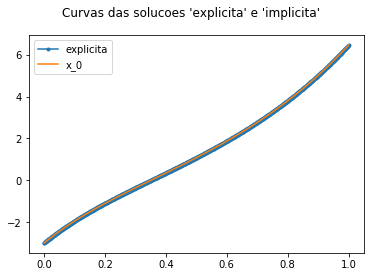

In [17]:
coeff = np.array([1, 4, -7, -10, 0])
u_zero = np.array([-3, 12, -36])
fig, ax = plt.subplots(ncols=1, nrows=1) 
fig.suptitle("Curvas das solucoes 'explicita' e 'implicita'")
ts = np.linspace(0,1, 10**3)
analitical = (-5/2)*np.exp(-1*ts) + np.exp(2*ts) + (-3/2)*np.exp(-5*ts)
ax.plot(ts, analitical, '.-', label='explicita')
num = exibe_solucao_2(coeff, u_zero, t=1, figu=fig, axe=ax, ret=True)[0]

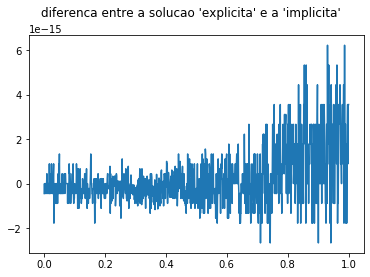

In [18]:
plt.plot(ts, analitical - num)
plt.suptitle("diferenca entre a solucao 'explicita' e a 'implicita'")
plt.show()

###### Exemplo 2:

Considere a seguinte ED: 

$$ u^{(4)} + 8 u'' + 16u = 0   $$

com condições iniciais $u(0) = -1, u'(0) = 5, u''(0) = -8, u'''(0) = -28$.

A solução analítica é, neste caso, $u(t) = -\mathrm{cos}(2t) + 2 \mathrm{sen}(2t) + t \mathrm{cos}(2t) - 3t \mathrm{sen}(2t)$

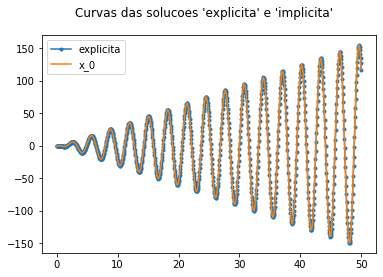

In [19]:
coeff = np.array([1, 0, 8, 0, 16, 0])
u_zero = np.array([-1, 5, -8, -28])
fig, ax = plt.subplots(ncols=1, nrows=1) 
fig.suptitle("Curvas das solucoes 'explicita' e 'implicita'")
t = 50
ts = np.linspace(0,t, 10**3)
analitical = -1*np.cos(2*ts) + 2*np.sin(2*ts) + np.multiply(ts, np.cos(2*ts)) - 3*np.multiply(ts, np.sin(2*ts))
ax.plot(ts, analitical, '.-', label='explicita')
num = exibe_solucao_2(coeff, u_zero, t=t, figu=fig, axe=ax, ret=True)[0]

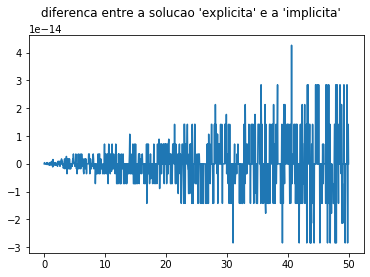

In [20]:
plt.plot(ts, analitical - num)
plt.suptitle("diferenca entre a solucao 'explicita' e a 'implicita'")
plt.show()

Referências:

$[1]$ - Lennart Edsberg, Introduction to Computation and Modeling for Differential Equations, Wiley-Interscience, New York, NY, 2008